<a href="https://colab.research.google.com/github/sejeong-park/Energy_Consumption/blob/main/household_power_consumption_using_LSTM%26GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import KFold 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools

In [69]:
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [5]:
df=pd.read_csv('household_power_consumption.txt',sep=';',parse_dates={'dt':['Date','Time']},infer_datetime_format=True,low_memory=False,na_values=['nan','?'],index_col='dt')

In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [9]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [10]:
df.shape

(2075259, 7)

In [11]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [12]:
droping_list_all=[]
for j in range(0,7):
  if not df.iloc[:,j].notnull().all():
    droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [13]:
for j in range(0,7):
  df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [14]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
df.shape

(2075259, 7)

In [16]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


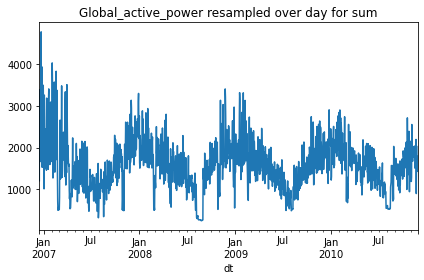

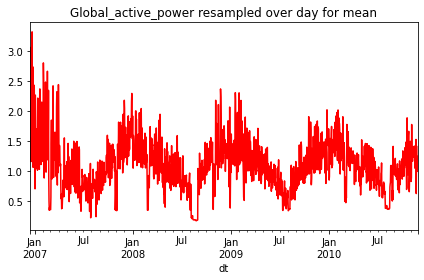

In [18]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
plt.tight_layout()
plt.show()

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean',color='red')
plt.tight_layout()
plt.show()

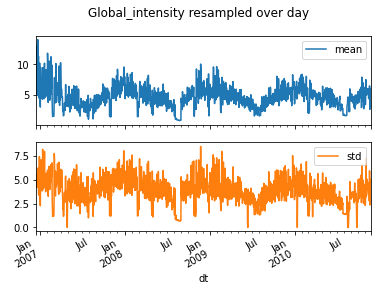

In [19]:
r=df.Global_intensity.resample('D').agg(['mean','std'])
r.plot(subplots=True,title='Global_intensity resampled over day')
plt.show()

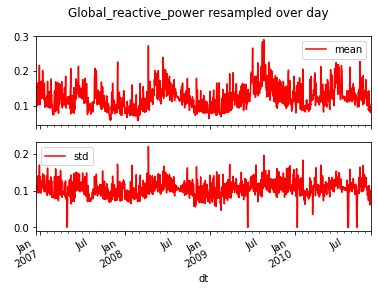

In [20]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

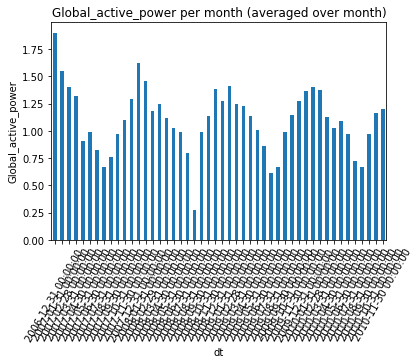

In [22]:
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

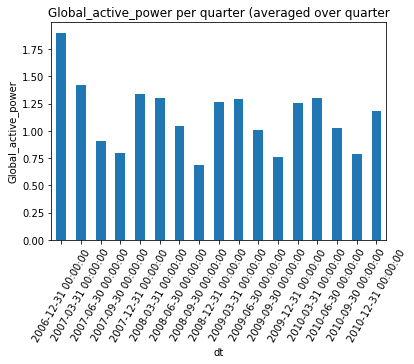

In [23]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter')
plt.show()

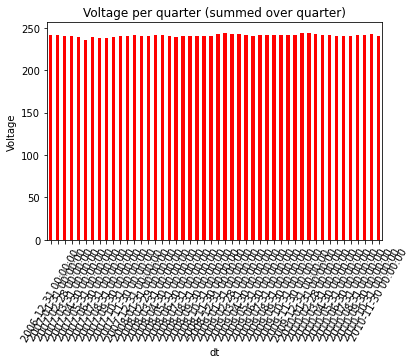

In [24]:
df['Voltage'].resample('M').mean().plot(kind='bar',color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

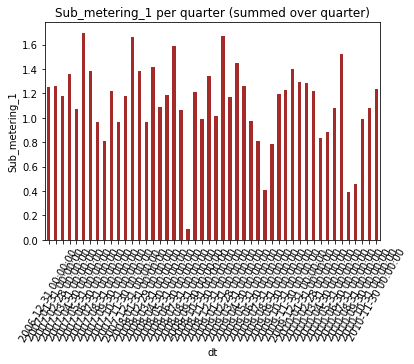

In [25]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar',color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

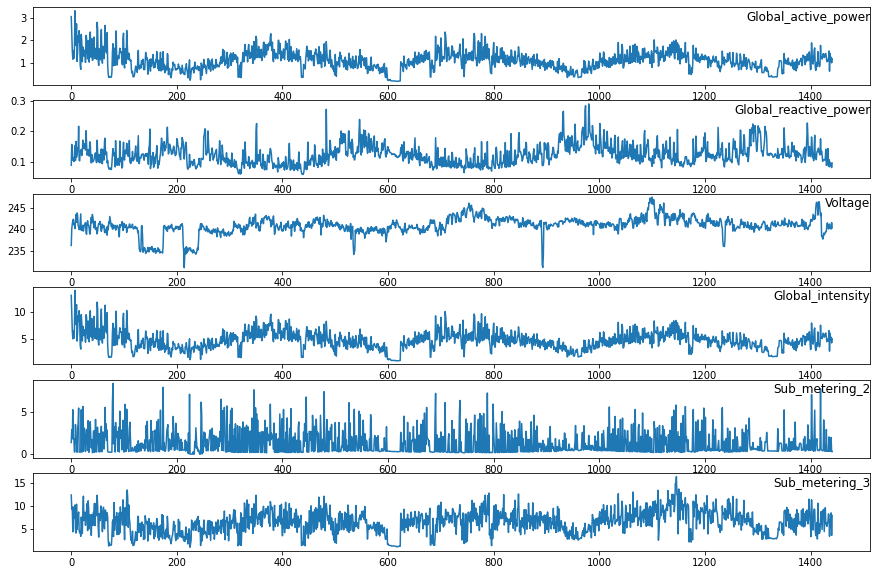

In [26]:
cols=[0,1,2,3,5,6]
i=1
groups=cols
values=df.resample('D').mean().values
plt.figure(figsize=(15,10))

for group in groups:
  plt.subplot(len(cols),1,i)
  plt.plot(values[:,group])
  plt.title(df.columns[group],y=0.75,loc='right')
  i+=1
plt.show()

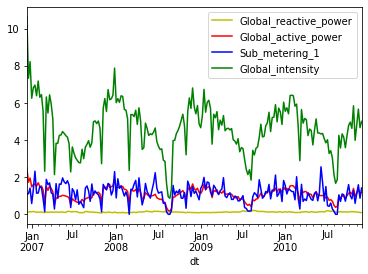

In [27]:
df.Global_reactive_power.resample('W').mean().plot(color='y',legend=True)
df.Global_active_power.resample('W').mean().plot(color='r',legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b',legend=True)
df.Global_intensity.resample('W').mean().plot(color='g',legend=True)
plt.show()

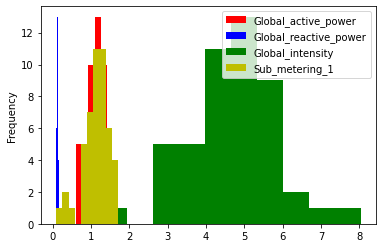

In [28]:
df.Global_active_power.resample('M').mean().plot(kind='hist',color='r',legend=True)
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b',legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist',color='g',legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist',color='y',legend=True)
plt.show()

# 모델 학습

In [133]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [136]:
df_resample=df.resample('h').mean()
df_resample.shape

(34589, 7)

In [137]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.636816   0.295738   0.337945  ...   0.011366   0.782418  0.545045
2   0.545045   0.103358   0.335501  ...   0.144652   0.782676  0.509006
3   0.509006   0.110073   0.283802  ...   0.030869   0.774169  0.488550
4   0.488550   0.096987   0.315987  ...   0.000000   0.778809  0.455597
5   0.455597   0.099010   0.434417  ...   0.008973   0.798917  0.322555

[5 rows x 8 columns]


In [138]:
values=reframed.values
n_train_time=365*24

train=values[:n_train_time,:]
test=values[n_train_time:,:]

train_X,train_y=train[:,:-1],train[:,-1]
test_X,test_y=test[:,:-1],test[:,-1]

train_X=train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X=test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


# LSTM

**Model architectture**

1) LSTM with 100 neurons in the first visible layer

2) dropout 20%

3) 1 neuron in the output layer for predicting Global_active_power

4) The input shape will be 1 time step with 7 features

5) MAE

6) The model will be fit for 20 training epochs with a batch size of 70


In [120]:
model=Sequential()
model.add(LSTM(100,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
history=model.fit(train_X,train_y,epochs=20,batch_size=70,validation_data=(test_X,test_y),verbose=2,shuffle=False)

Epoch 1/20
126/126 - 3s - loss: 0.0197 - val_loss: 0.0118
Epoch 2/20
126/126 - 1s - loss: 0.0126 - val_loss: 0.0106
Epoch 3/20
126/126 - 1s - loss: 0.0114 - val_loss: 0.0098
Epoch 4/20
126/126 - 1s - loss: 0.0110 - val_loss: 0.0093
Epoch 5/20
126/126 - 1s - loss: 0.0107 - val_loss: 0.0092
Epoch 6/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 7/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0091
Epoch 8/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0091
Epoch 9/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 10/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 11/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 12/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 13/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 14/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 15/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 16/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 17/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 

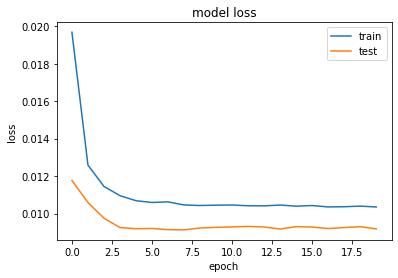

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')
plt.show()

In [123]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.617


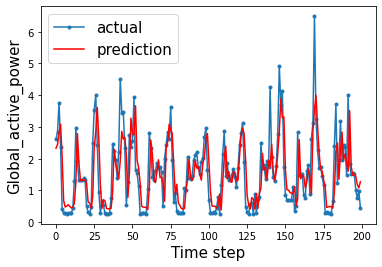

In [124]:
a=[x for x in range(200)]
plt.plot(aa,inv_y[:200],marker='.',label='actual')
plt.plot(aa,inv_yhat[:200],'r',label='prediction')
plt.ylabel('Global_active_power',size=15)
plt.xlabel('Time step',size=15)
plt.legend(fontsize=15)
plt.show()

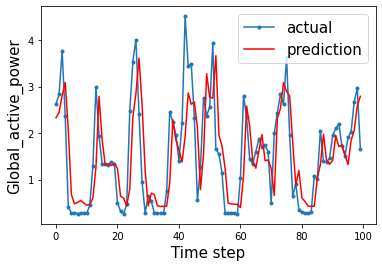

In [125]:
aa=[x for x in range(100)]
plt.plot(aa,inv_y[:100],marker='.',label='actual')
plt.plot(aa,inv_yhat[:100],'r',label='prediction')
plt.ylabel('Global_active_power',size=15)
plt.xlabel('Time step',size=15)
plt.legend(fontsize=15)
plt.show()

In [129]:
df_resample=df.resample('h').mean()
df_resample.shape

(34589, 7)

In [130]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.636816   0.295738   0.337945  ...   0.011366   0.782418  0.545045
2   0.545045   0.103358   0.335501  ...   0.144652   0.782676  0.509006
3   0.509006   0.110073   0.283802  ...   0.030869   0.774169  0.488550
4   0.488550   0.096987   0.315987  ...   0.000000   0.778809  0.455597
5   0.455597   0.099010   0.434417  ...   0.008973   0.798917  0.322555

[5 rows x 8 columns]


# GRU

In [139]:
model=Sequential()
model.add(GRU(100,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [140]:
history=model.fit(train_X,train_y,epochs=20,batch_size=70,validation_data=(test_X,test_y),verbose=2,shuffle=False)

Epoch 1/20
126/126 - 3s - loss: 0.0153 - val_loss: 0.0106
Epoch 2/20
126/126 - 1s - loss: 0.0115 - val_loss: 0.0099
Epoch 3/20
126/126 - 1s - loss: 0.0110 - val_loss: 0.0096
Epoch 4/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0097
Epoch 5/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0095
Epoch 6/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0095
Epoch 7/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0094
Epoch 8/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0095
Epoch 9/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0096
Epoch 10/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0096
Epoch 11/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0095
Epoch 12/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0096
Epoch 13/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0097
Epoch 14/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0095
Epoch 15/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0095
Epoch 16/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0097
Epoch 17/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0096
Epoch 

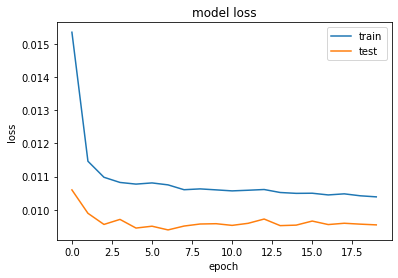

In [141]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')
plt.show()

In [142]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.629


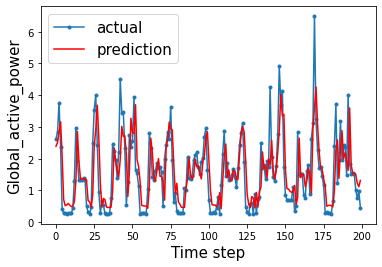

In [144]:
b=[x for x in range(200)]
plt.plot(b,inv_y[:200],marker='.',label='actual')
plt.plot(b,inv_yhat[:200],'r',label='prediction')
plt.ylabel('Global_active_power',size=15)
plt.xlabel('Time step',size=15)
plt.legend(fontsize=15)
plt.show()

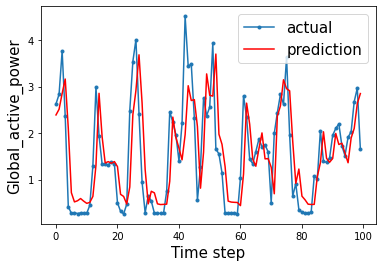

In [145]:
bb=[x for x in range(100)]
plt.plot(bb,inv_y[:100],marker='.',label='actual')
plt.plot(bb,inv_yhat[:100],'r',label='prediction')
plt.ylabel('Global_active_power',size=15)
plt.xlabel('Time step',size=15)
plt.legend(fontsize=15)
plt.show()

LSTM GRU 비교

In [114]:
plt.subplot(2 2 1)
plt.plot(a)


SyntaxError: ignored

In [65]:
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])


model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
print(model.summary())

NameError: ignored